<a href="https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/src/MyModel/BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert-Model


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Steps to import python files in Collaboratory
- go to Google Drive where the Jupyter Notebook containing the desired functions to import is
- download it with the .py extension
- run the following cell to put it in the content space

In this particular case we would need to import as a module the NTN file, containing the Neural Tensor Network implementation

In [3]:
from google.colab import files

files.upload()

Saving NTN.py to NTN.py


{'NTN.py': b'# -*- coding: utf-8 -*-\n"""NTN.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/NTN.ipynb\n"""\n\nimport torch\nimport torch.nn as nn\nfrom typing import Tuple, List\nimport numpy as np\nfrom torch.utils.data import DataLoader, RandomSampler, SequentialSampler\n\nclass NeuralTensorNetwork(nn.Module):\n    def __init__(self, output_dim: int, input_dim: int, activation: str="tanh", mean: float=0.0, std: float=1.0):\n        \n        super(NeuralTensorNetwork, self).__init__()\n\n        # setting input and output dimensions\n        self.k = output_dim\n        self.d = input_dim # e1,e2\n\n        # setting mean and std for random initialization\n        self.mean = mean\n        self.std = std\n\n        self.activation = activation\n\n        # parameters has been used in order to consider W, V, b as model parameters\n        #

In [4]:
import NTN

In [5]:
import pandas as pd 
import numpy as np 
import re

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import gc
from typing import Tuple, List
import torch.optim as opt

In [20]:
def load_embeds(folder: str, kind:str)-> np.ndarray:
    output = np.load(root+f"BERT/{folder}/bert_emb_{kind}_100.npy")
    for i in range(1,20):
        tmp = np.load(root+f"BERT/{folder}/bert_emb_{kind}_{(i+1)*100}.npy")
        print(f"iteration {i}\n")
        print(f"len tmp {len(tmp)}\n")
        output = np.concatenate((output,tmp))
        print(f"len {kind}_embs {len(output)}\n")
        gc.collect()
    return output

In [6]:
root = '/content/gdrive/MyDrive/Colab Notebooks/Polarity-Subjectivity-Detection/'

In [16]:
pol_embs = load_embeds(folder='Polarity-Embeddings', kind='pol')

iteration 1

len tmp 100

len pol_embs 200

iteration 2

len tmp 100

len pol_embs 300

iteration 3

len tmp 100

len pol_embs 400

iteration 4

len tmp 100

len pol_embs 500

iteration 5

len tmp 100

len pol_embs 600

iteration 6

len tmp 100

len pol_embs 700

iteration 7

len tmp 100

len pol_embs 800

iteration 8

len tmp 100

len pol_embs 900

iteration 9

len tmp 100

len pol_embs 1000

iteration 10

len tmp 100

len pol_embs 1100

iteration 11

len tmp 100

len pol_embs 1200

iteration 12

len tmp 100

len pol_embs 1300

iteration 13

len tmp 100

len pol_embs 1400

iteration 14

len tmp 100

len pol_embs 1500

iteration 15

len tmp 100

len pol_embs 1600

iteration 16

len tmp 100

len pol_embs 1700

iteration 17

len tmp 100

len pol_embs 1800

iteration 18

len tmp 100

len pol_embs 1900

iteration 19

len tmp 100

len pol_embs 2000



In [21]:
subj_embs = load_embeds(folder='Subjectivity-Embeddings', kind='subj')

iteration 1

len tmp 100

len subj_embs 200

iteration 2

len tmp 100

len subj_embs 300

iteration 3

len tmp 100

len subj_embs 400

iteration 4

len tmp 100

len subj_embs 500

iteration 5

len tmp 100

len subj_embs 600

iteration 6

len tmp 100

len subj_embs 700

iteration 7

len tmp 100

len subj_embs 800

iteration 8

len tmp 100

len subj_embs 900

iteration 9

len tmp 100

len subj_embs 1000

iteration 10

len tmp 100

len subj_embs 1100

iteration 11

len tmp 100

len subj_embs 1200

iteration 12

len tmp 100

len subj_embs 1300

iteration 13

len tmp 100

len subj_embs 1400

iteration 14

len tmp 100

len subj_embs 1500

iteration 15

len tmp 100

len subj_embs 1600

iteration 16

len tmp 100

len subj_embs 1700

iteration 17

len tmp 100

len subj_embs 1800

iteration 18

len tmp 100

len subj_embs 1900

iteration 19

len tmp 100

len subj_embs 2000



In [24]:
gc.collect()

44

In [25]:
print(len(pol_embs))
print(type(pol_embs))

2000
<class 'numpy.ndarray'>


In [28]:
print(len(subj_embs))
print(type(subj_embs))

2000
<class 'numpy.ndarray'>


In [ ]:
# first batch. When doing np.save everything is flatten up
# need to rebuild the features to have a list of 2k elements to spit up
print(pol_emb[:64])

[[-0.52265924  0.45974758 -0.10843666 ... -0.25197148  0.77466035
  -0.33106545]
 [-0.75030386  0.4505008   0.56886244 ...  0.43157658  0.6804023
  -0.0853495 ]
 [-1.2998611  -0.01715478  0.13079669 ...  0.05302947  0.5271785
  -0.2552826 ]
 ...
 [-0.73318154  0.86959463  0.208814   ... -0.32357198  0.05216676
   0.7314429 ]
 [-0.43171325 -0.7715653   1.1424894  ... -0.20544964 -0.19744898
   0.3798657 ]
 [-0.547649   -0.15794809  0.43729606 ... -0.00554502 -0.5561865
  -1.3193834 ]]


In [ ]:
print(pol_emb[0].shape)

(768,)


In [ ]:
pol_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = pol_emb[:512]
    else:    
        chunk = pol_emb[i-512:i]
        pol_emb_arranged.append(chunk)

print(len(pol_emb_arranged))
#print(pol_emb_arranged)

2000


In [ ]:
subj_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = subj_emb[:512]
    else:    
        chunk = subj_emb[i-512:i]
        subj_emb_arranged.append(chunk)

print(len(subj_emb_arranged))
#print(pol_emb_arranged)

2000


In [ ]:
torch.cuda.empty_cache()
gc.collect()

1012

## Train/Test split
Preparing the data to be fed to the model

In [ ]:
senti_labels = [1 if idx<1000 else 0 for idx in range(2000)]

In [ ]:
pos = senti_labels[:1000]
neg = senti_labels[1000:]

In [ ]:
len(pos)

1000

In [ ]:
len(neg)

1000

In [ ]:
subj_labels = torch.tensor([1 if idx<1000 else 0 for idx in range(2000)])

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler

def get_data(pol_embs: List, subj_embs: List, pol_labels: List, 
             subj_labels: List, batch_size: int, random_state=42, 
             test_split=0.2) -> Tuple[torch.utils.data.DataLoader]:

    senti_train, senti_test, sentlabel_train, sentlabel_test = train_test_split(pol_embs, 
                                                                                pol_labels,
                                                                                test_size=test_split, 
                                                                                random_state=random_state)
    
    sub_train, sub_test, sublabel_train, sublabel_test = train_test_split(subj_embs, 
                                                                          subj_labels, 
                                                                          test_size=test_split, 
                                                                          random_state=random_state)
    
    sent_train = list(zip(senti_train, sentlabel_train))
    sent_test = list(zip(senti_test, sentlabel_test))
    sub_train = list(zip(sub_train, sublabel_train))
    sub_test = list(zip(sub_test, sublabel_test))
    
    #for element in sent_train:
    #    print(f"pol : {element[0]}", f"lab : {element[1]}")
  
    
    pol_train_loader = DataLoader(dataset=sent_train, 
                              batch_size=batch_size, 
                              sampler=RandomSampler(sent_train), 
                              shuffle=False)
    
    pol_validation_loader = DataLoader(dataset=sent_test, 
                                   batch_size=batch_size,
                                   sampler=RandomSampler(sent_test), 
                                   shuffle=False)

    sub_train_loader = DataLoader(dataset=sub_train, 
                              batch_size=batch_size, 
                              sampler=RandomSampler(sub_train), 
                              shuffle=False)
    
    sub_validation_loader = DataLoader(dataset=sub_test, 
                                   batch_size=batch_size,
                                   sampler=RandomSampler(sub_test), 
                                   shuffle=False)
    
    #for idx, item in enumerate(pol_train_loader):
    #    print(f"idx : {idx} \n pol : {item[0]} \n label : {item[1]}")
    
    return pol_train_loader, pol_validation_loader, sub_train_loader, sub_validation_loader

In [ ]:
sent_train, sent_val, sub_train, sub_val = get_data(pol_embs=pol_emb_arranged, 
                                                    subj_embs=subj_emb_arranged,
                                                    pol_labels=senti_labels,
                                                    subj_labels=subj_labels,
                                                    batch_size=64)

## Model assembly

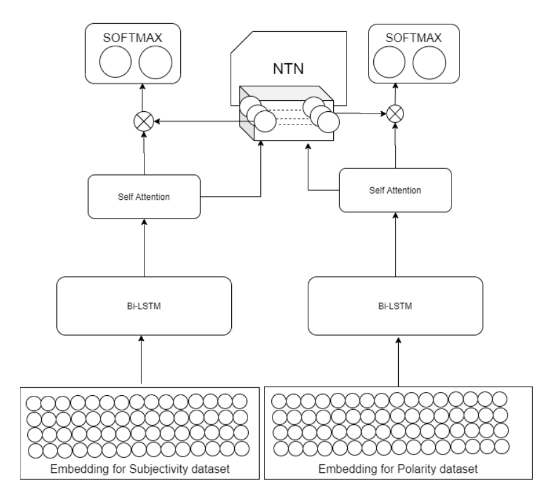

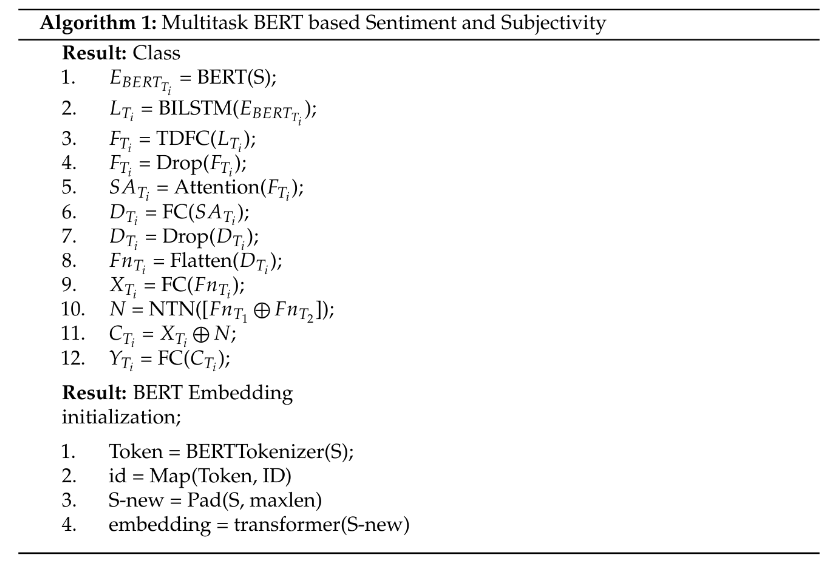


In [ ]:
class MLT(nn.Module):

    def __init__(self, num_heads: int):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.LSTM1 = nn.LSTM(input_size=768, hidden_size=128, dropout=0.2, bidirectional=True)
        self.LSTM2 = nn.LSTM(input_size=768, hidden_size=128, dropout=0.2, bidirectional=True)

        # dense layers
        self.dense1 = nn.Linear(in_features=128*2, out_features=128)
        self.dense2 = nn.Linear(in_features=128*2, out_features=128)
        
        # dropout layers
        #self.drop1 = nn.Dropout(p=0.5)
        #self.drop2 = nn.Dropout(p=0.5)

        # self-attention layers
        #self.attention1 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads)
        #self.attention2 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads)

        #self.dense11 = nn.Linear(in_features=)
        #return self.attention1, self.attention2

    def forward(self, emb1, emb2) -> Tuple:
        print(type(emb2))
        print(type(emb2))
        print(torch.Size(emb1))
        print(torch.Size(emb1))
        lstm1 = self.LSTM1(emb1)
        lstm2 = self.LSTM1(emb2)

        print(f"Type lstm1 : {type(lstm1)}")
        print(f"Type lstm2 : {type(lstm2)}")
        print(f"Len lstm1 : {len(lstm1)}")
        print(f"Len lstm2 : {len(lstm2)}")


        print(torch.Size(lstm1))

        dense1 = self.dense1(lstm1)
        dense2 = self.dense2(lstm2)


        #drop1 = self.drop(dense1)
        #drop2 = self.drop(dense2)

        #attention_layer1 = self.attention1(drop1)
        #attention_layer2 = self.attention2(drop2)

        #return attention_layer1, attention_layer2
        

In [ ]:
def cross_entropy_loss():
    return torch.nn.CrossEntropyLoss()

In [ ]:
def get_optimizer(net, lr: float=0.0002):
    return opt.Adam(net.params(), lr=lr)

In [ ]:
def training_step(model, sent_train: torch.utils.data.DataLoader, 
                  sub_train: torch.utils.data.DataLoader, device: str = 'cuda:0') -> Tuple[float]:
    
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.
  
    model.train() 

    sub_train = iter(sub_train)
 
    # iterate over the training set
    for batch_idx, item in enumerate(sent_train):
        # load data into GPU
        pol_inputs = item[0].to(device)
        pol_targets = item[1].to(device)

        sub_inputs = next(sub_train)[0].to(device)
        sub_targets = next(sub_train)[1].to(device)

        #print(sub_targets)
        #print(pol_inputs)
        #print(type(sub_inputs))

        #print(type(pol_inputs))

        # forward pass -> the output should be two vecotors.
        # as a consequence two losses
        pol_out, sub_out = model(pol_inputs, sub_inputs)

        # loss computation
        #pol_loss = cross_entropy_loss(pol_out, pol_targets)
        #sub_loss = cross_entropy_loss(sub_inputs, sub_targets)
        
        # backward pass
        #pol_loss.backward()
        #sub_loss.backward()
    
        # parameters update
        #get_optimizer.step()

        # gradients reset
        #get_optimizer.zero_grad()

        # fetch prediction and loss value for polarity 
        #samples_pol += pol_inputs.shape[0]
        #cumulative_loss_pol += pol_loss.item()
        #_, predicted_pol = pol_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

        # compute training accuracy
        #cumulative_accuracy_pol += predicted_pol.eq(pol_targets).sum().item()
        
        # fetch prediction and loss value for subjectivity dataset
        #samples_sub += sub_inputs.shape[0]
        #cumulative_loss_sub += sub_loss.item()
        #_, predicted_sub = sub_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

        # compute training accuracy
        #cumulative_accuracy_sub += predicted_sub.eq(sub_targets).sum().item()

    #return cumulative_loss_pol/samples_pol,(cumulative_accuracy_pol/samples_pol)*100, cumulative_loss_sub/samples_sub, (cumulative_accuracy_sub/samples_sub)*100    

In [ ]:
def test_step(net, pol_test: torch.utils.data.DataLoader, 
              sub_test: torch.utils.data.DataLoader, 
              device='cuda:0')->Tuple[float]:

    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    net.eval()
    sub_test = iter(sub_train)

    with torch.no_grad():

        for batch_idx, item in enumerate(pol_test):

            # load data into GPU
            pol_inputs = item[0].to(device)
            pol_targets = item[1].to(device)

            sub_inputs = sub_test[0].to(device)
            sub_targets = sub_test[1].to(device)
        
            # forward pass
            pol_out, sub_out = net(pol_inputs, sub_inputs)

            # apply the loss
            pol_loss = cross_entropy_loss(pol_out, pol_targets)
            sub_loss = cross_entropy_loss(sub_inputs, sub_targets)

            sub_train = next(sub_train)
        
            # backward pass
            pol_loss.backward()
            sub_loss.backward()

            # fetch prediction and loss value for polarity 
            samples_pol += pol_inputs.shape[0]
            cumulative_loss_pol += pol_loss.item()
            _, predicted_pol = pol_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

            # compute training accuracy
            cumulative_accuracy_pol += predicted_pol.eq(pol_targets).sum().item()
        
            # fetch prediction and loss value for subjectivity dataset
            samples_sub += sub_inputs.shape[0]
            cumulative_loss_sub += sub_loss.item()
            _, predicted_sub = sub_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

            # compute training accuracy
            cumulative_accuracy_sub += predicted_sub.eq(sub_targets).sum().item()

    
    return cumulative_loss_pol/samples_pol,(cumulative_accuracy_pol/samples_pol)*100, cumulative_loss_sub/samples_sub, (cumulative_accuracy_sub/samples_sub)*100    

In [ ]:
def main(pol_train_loader,
         pol_test_loader,
         sub_train_loader,
         sub_test_loader,
         batch_size=64,
         device='cuda:0',
         epochs=15) -> Tuple[float]:
  
  
    net = MLT(num_heads=4).to(device)
    print('Network Init Done')

    tup = training_step(net, pol_train_loader, sub_train_loader)

    #for e in range(epochs):
    #    print(f"Epoch {e}:")

    #    tup = training_step(net, pol_train_loader, sub_train_loader)
        #pol_train_loss, pol_train_accuracy, sub_train_loss, sub_train_accuracy = training_step(net, pol_train_loader, sub_train_loader)
        #print(f"Polarity training loss: {pol_train_loss} \n Pol training accuracy: {pol_train_accuracy} \n Sub training loss: {sub_train_loss} \n Sub training acuracy: {sub_train_accuracy}")

    # perform final test step and print the final metrics
    #_, test_accuracy = test_step(net, pol_test_loader, sub_test_loader)

    #return test_accuracy

In [ ]:
main(pol_train_loader=sent_train, pol_test_loader=sent_val, sub_train_loader=sub_train, sub_test_loader=sub_val)

Network Init Done
<class 'torch.Tensor'>
<class 'torch.Tensor'>


TypeError: ignored

In [ ]:
# history=model.fit([senti_train, sub_train], [sentlabel_train,sublabel_train], batch_size= 64, epochs=20, verbose=1, shuffle=True, validation_split=0.2)

### Unused

In [ ]:
#pol_emb = np.load(root + 'pol.npy')
#subj_emb = np.load(root + 'subj_obj.npy')

#pol_embs = np.load(root+'BERT/Polarity-Embeddings/bert_emb_pol_100.npy')
#for i in range(1,20):
#    tmp = np.load(root+f'BERT/Polarity-Embeddings/bert_emb_pol_{(i+1)*100}.npy')
#    print(f"iteration {i}\n")
#    print(f"len tmp {len(tmp)}\n")
#    pol_embs = np.concatenate((pol_embs,tmp))
#    print(f"len pol_embs {len(pol_embs)}\n")